Dot Plot
-----

https://github.com/mattcrooksphd/Medium-Dot-Plot

In [1]:
from collections import OrderedDict
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
from random import sample

class create_dot_plot(object):

    def __init__(self,
                 data_dict,
                 reversed_rows=None,
                 title=None,
                 ignore_labels=True,
                 nb_rows=31,
                 nb_columns=32
                 ):

        rcParams['font.size'] = 16
        rcParams['font.family'] = 'serif'
        rcParams['text.color'] = 'grey'
        rcParams['savefig.bbox'] = 'tight'
        rcParams['savefig.dpi'] = 500
        rcParams['savefig.transparent'] = True

        self.class_labels = list(data_dict.keys())
        if len(self.class_labels) > 10:
            raise ValueError('There are more than 10 classes, consider reducing this for optimal visualisation')

        total = sum(data_dict.values())
        data_dict = OrderedDict(sorted({key: int(np.round(nb_rows*nb_columns * data_dict[key] / total, 0)) for key in data_dict}.items(), key=lambda x: x[1]))
        data_dict[list(data_dict.keys())[-1]] = nb_rows*nb_columns-sum([v for k, v in list(data_dict.items())[:-1]])
        self.data_dict = data_dict

        self.color_dict = {c[0]: c[1] for c in zip(data_dict, sample(mcolors.TABLEAU_COLORS.keys(), k=len(data_dict)))}
        self.color_dict_named_colors = {f"color_{key}": self.color_dict[key] for key in self.color_dict}
        self.color_dict = {key: f"color_{key}" for key in self.color_dict}

        self.n_grid = nb_columns
        self.m_grid = nb_rows
        self.reversed_rows = reversed_rows
        self.ignore_labels = ignore_labels

        self.ordered_data_dict = OrderedDict({label: self.data_dict[label] for label in self.class_labels})
        self.color_options = [self.color_dict[label] for label in self.class_labels]
        self.color_dict_reversed = {self.color_dict[key]: key for key in self.color_dict}
        self.class_pc = [self.data_dict[label] for label in self.class_labels]

        figsize = (int(nb_columns/1.1), int(nb_rows/1.1))
        dot_size = 100

        self.dot_plot(dot_size=dot_size, figsize=figsize)
        if not self.ignore_labels:
            self.add_labels()
        if title is not None:
            self._add_title(title)
        self._add_caption('Each dot represents ~ %.1f %%.'%(1./(nb_rows*nb_columns)*100))

        self.ax.set_xlim(-0.8, self.n_grid + 0.8)
        self.ax.set_ylim(-0.8, self.m_grid - 1 + 0.8)

    def _add_title(self, title):
        self.ax.text((self.n_grid - 1) / 2, self.m_grid, title.upper(), horizontalalignment = 'center', verticalalignment = 'center')

    def _add_caption(self, caption):
        self.ax.text(- 0.35, - 0.7, caption, horizontalalignment = 'left', verticalalignment = 'top', fontsize = 11)

    def _get_right_dot_row_info(self, right_dot_colors):

        right_dot_colors=[str(color) for color in right_dot_colors]
        right_dot_colors_dict=OrderedDict({color: 0 for color in right_dot_colors})
        for color in right_dot_colors:
            right_dot_colors_dict[color] += 1

        for color in self.color_dict_reversed:
            if color not in right_dot_colors_dict:
                raise ValueError(f"Class '{self.color_dict_reversed[color]}' does not have a dot on the right hand side")

        dot_row_range_dict={color: [] for color in right_dot_colors}
        dot_row_range_list=[]
        for i, color in enumerate(right_dot_colors_dict):
            if i == 0:
                dot_row_range_list=[[0, right_dot_colors_dict[color] - 1]]
            else:
                if right_dot_colors_dict[color] == 1:
                    dot_row_range_list.append([dot_row_range_list[-1][-1] + 1])
                else:
                    dot_row_range_list.append([dot_row_range_list[-1][-1] + 1,
                                               dot_row_range_list[-1][-1] + right_dot_colors_dict[color]])
        self.dot_row_range_dict=dict(zip(right_dot_colors_dict, dot_row_range_list))
        self.label_dot_row_range_dict={}
        for label in self.class_labels:
            self.label_dot_row_range_dict[label]=self.dot_row_range_dict[self.color_dict[label]]

    def dot_plot(self, dot_size = None, figsize = None):

        color_options=[self.color_dict[label] for label in self.class_labels]
        xcentres=range(self.n_grid)
        ycentres=range(self.m_grid)
        X, Y=np.meshgrid(xcentres, ycentres)
        for row in range(X.shape[0]):
            if self.reversed_rows is 'snake':
                if row % 2 == 1:
                    X[row, :]=np.fliplr(X[2, :].reshape(1, -1))[0]
            elif self.reversed_rows is None:
                None
            else:
                if row in self.reversed_rows:
                    X[row, :]=np.fliplr(X[2, :].reshape(1, -1))[0]

        if figsize is None:
            figsize=(self.n_grid + 1, self.m_grid)

        self.f, self.ax=plt.subplots(1, 1, figsize=figsize)
        self.ax.set_axisbelow=False

        dot_colors=[]
        for class_number, n_dots in enumerate(self.class_pc):
            dot_colors += [color_options[class_number]] * n_dots
        dot_colors += ['silver'] * (self.n_grid * self.m_grid - len(dot_colors))

        if not self.ignore_labels:
            right_dot_ids=(X == (self.n_grid - 1)).reshape(1, -1)[0]
            self._get_right_dot_row_info(np.array(dot_colors)[right_dot_ids])

        self.ax.scatter(X.reshape(1, -1),
                        Y.reshape(1, -1),
                        s = dot_size,
                        color = [self.color_dict_named_colors[color] for color in dot_colors[:self.n_grid * self.m_grid]],
                        edgecolor = None)

        plt.axis('off')


    def add_labels(self):
        [self._add_label(label) for label in self.class_labels]

    def _add_label(self, label):

        dash_width=0.3

        dot_row_range=self.label_dot_row_range_dict[label]

        if type(dot_row_range) == int:
            dot_row_range=[dot_row_range]

        if len(dot_row_range) == 1:
            mid_point=dot_row_range[0]
        else:
            mid_point=0.5 * dot_row_range[0] + 0.5 * dot_row_range[1]

        if len(dot_row_range) == 2:
            self.ax.plot([self.n_grid - dash_width, self.n_grid, self.n_grid, self.n_grid - dash_width],
                         [dot_row_range[0], dot_row_range[0], dot_row_range[1], dot_row_range[1]],
                         color = self.color_dict_named_colors[self.color_dict[label]])
            self.ax.plot([self.n_grid, self.n_grid + dash_width],
                         [mid_point] * 2,
                         color = self.color_dict_named_colors[self.color_dict[label]])
        else:
            self.ax.plot([self.n_grid - dash_width, self.n_grid + dash_width],
                         dot_row_range * 2,
                         color = self.color_dict_named_colors[self.color_dict[label]])

        self.ax.text(self.n_grid + 2 * dash_width, mid_point, label,
                     horizontalalignment = 'left', 
                     verticalalignment = 'center',
                     color = self.color_dict_named_colors[self.color_dict[label]]
        )

In [2]:
data = {
    "B1": 400,
    "B2": 400,
    "B3": 200,
    "C1": 200,
    "C2": 200,
    "D": 180,
    "E": 60
      }

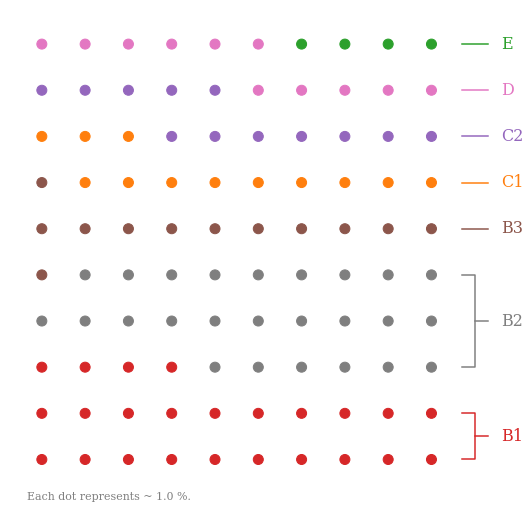

In [3]:
dotplot_figure = create_dot_plot(
    
    nb_rows=10,
    nb_columns=10,
        
    data_dict = data,

    reversed_rows=[4],
    
    ignore_labels=False,
    title='')